In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [1]:
from tensorboardX import SummaryWriter
from tqdm import tqdm
import gc
from copy import deepcopy
from gym_point import PointEnv

import torch
import numpy as np
from torch import nn
import math
from models import *   
from train_barrier_point import *
from core import generate_default_model_name

import scipy
from random import shuffle
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from collections import defaultdict

# train offline

In [4]:
Env = PointEnv
env = PointEnv()
name_dict = generate_default_model_name(Env)
bnn = DMLP(state_dim=Env.state_dim, action_dim=Env.action_dim, mode='straight')
bnn.to(device)
bnn.load_state_dict(torch.load(name_dict['db'].replace('dbgnn', 'dbnn'), map_location=device))
bnn.train()

DMLP(
  (vec): Sequential(
    (0): Linear(in_features=2, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (field): Sequential(
    (0): Linear(in_features=1026, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [17]:
from gym_point import PointEnv
from stable_baselines3 import PPO
from tqdm import tqdm
from collections import defaultdict

Env = PointEnv
env = PointEnv()

def nominal_control(x):
    return np.array([2, 0]-x).clip(-1, 1)

bnn = DMLP(state_dim=Env.state_dim, action_dim=Env.action_dim, mode='straight')
bnn.to(device)
bnn.train()

name_dict = generate_default_model_name(Env)
# bnn.load_state_dict(torch.load(name_dict['b'].replace('.pt', '_1model.pt'), map_location=device))

boptimizer = torch.optim.SGD(bnn.parameters(), lr=1e-3, weight_decay=0, momentum=0.9)
bscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(boptimizer, factor=0.5, patience=10)  

writer = SummaryWriter()
writer.step = 0
max_episode_length = 256

BATCH = 512
N_ITER = 10
N_EPOCH = 12000
N_TRAJ = 1000
N_TRAJ_PER_EPOCH = 1
N_BUFFER = 10
N_CBUF = 1000
N_EVALUATE = 100
THRESHOLD=1e-2

running_unsafe_rate = 0
best_unsafe_rate = float('inf')
unsafe_rates = [1.]*N_EVALUATE
nominal_eps = 1.0
explore_eps = 1.0

trajs = defaultdict(list)
BMODEL_PATH = name_dict['db'].replace('dbgnn', 'dbnn')
open('1model_'+Env.__name__+'.txt', 'w+').close()
bbuf_gather = GatherReplayBuffer(BATCH)
cbuf = GlobalReplayBuffer()
fbuf = GlobalReplayBuffer()

pbar = tqdm(range(N_TRAJ))
for epoch_i in pbar:
    
    bbuf = GlobalReplayBuffer()

    env.reset()
    # env.state = env.state + np.random.uniform(-2e-2, 2e-2, size=(2,))
#     env.world.agents = env.world.sample_agents(env.num_agents, prob=0.0)
    total_trans=0; n_danger=0; threshold=THRESHOLD; no_feasible=0; collided=False
    trajs[epoch_i].append(env._get_obs())

    while True:
        o = env._get_obs()
        a_all = np.random.uniform(-1, 1, size=(n_candidates, env.action_dim))  # np.hstack([i.reshape(-1, 1) for i in np.meshgrid(*([np.linspace(-1, 1, 20)]*2))])

        o = {'x': torch.FloatTensor(o), 'goal': torch.FloatTensor(env.goal)}
        a_refine, bvalue = iter_action(bnn, o, a_all, max_iter=0, threshold=threshold)  # min(epoch_i//10, 30)

        dists = []
        next_states = np.tile(env.world.agents.reshape(env.num_agents, 1, -1), (1, n_candidates, 1))
        ax, ay, theta = next_states[:, :, 0], next_states[:, :, 1], next_states[:, :, 2]
        theta = theta + 0.6*a_refines.squeeze(-1)
        dx, dy = 0.05*np.cos(theta), 0.05*np.sin(theta)
        next_states[:, :, 0] = ax + dx
        next_states[:, :, 1] = ay + dy
        theta = theta + (theta - 2* np.pi)*(theta>np.pi) + (theta + 2* np.pi)*(theta<-np.pi)
        next_states[:, :, 2] = theta
        
        if epoch_i < 10:  # warmup
            a = a_refine[np.argsort(dists)[0]]
        elif np.any(bvalue>threshold):
            for a_idx in np.argsort(dists):
                if bvalue[a_idx] > threshold:
                    a = a_refine[a_idx]
                    break
        else:
            no_feasible += 1
            if np.random.rand()<explore_eps:
                a = a_refine[np.random.randint(len(bvalue))]
            else:
                a = a_refine[np.argmax(bvalue)]

        # for zip(a, dists)

        # a, a_value = choose_action(a_refine, bvalue, threshold=threshold, explore_eps=0, nominal_eps=nominal_eps)  # 

        next_o, rw, done, info = env.step(a)

        bbuf.store(**info)
        prev_danger = info['prev_danger']
        next_danger = info['next_danger']
        if next_danger:
            cbuf.store(**info)
            if len(cbuf.obs_buf) > N_CBUF:
                cbuf.obs_buf.pop(0)
            collided = True

        total_trans += 1
        n_danger += np.array(next_danger).sum()
        trajs[epoch_i].append(env._get_obs())

        if done or (total_trans >= max_episode_length):
            # if n_danger!=0:
            #     meet_danger = False
            #     for o in bbuf.obs_buf:
            #         if meet_danger:
            #             o['prev_free'] = 0 * o['prev_free']
            #             o['next_free'] = 0 * o['next_free']
            #         if o['next_danger']:
            #             meet_danger = True
                # TODO: not feasible if next state is not feasible
                # for o in bbuf.obs_buf:
            bbuf_gather.append(bbuf)
            # else:
            #     fbuf.obs_buf.append(bbuf)
            break

    unsafe_rates.append(collided)
    unsafe_rates.pop(0)
    running_unsafe_rate = np.mean(unsafe_rates)
    if running_unsafe_rate < best_unsafe_rate:
        best_unsafe_rate = running_unsafe_rate
        torch.save(bnn.state_dict(), BMODEL_PATH)

    if len(bbuf_gather.buffers) > N_BUFFER:
        bbuf_gather.buffers.pop(0)

    if (epoch_i % N_TRAJ_PER_EPOCH) == (N_TRAJ_PER_EPOCH-1):
        bbuf_gather.buffers.append(cbuf)
        bnn.train()
        train_barrier(bnn, boptimizer, bbuf_gather, writer, pbar=pbar, n_iter=100)
        torch.save(bnn.state_dict(), BMODEL_PATH.replace('.pt', '_current.pt'))
        bbuf_gather.buffers.pop(-1)
        
    if (epoch_i % 100 == 99):
        explore_eps = explore_eps * 0.8
        
    if (epoch_i % 10 == 9):
        bscheduler.step(running_unsafe_rate)

    with open('1model_'+Env.__name__+'.txt', 'a+') as f:
        f.write(pbar.desc+'\t'+str(epoch_i)+'\t'+'collided: {0:d}'.format(int(collided))+' running rate: {0:.6f}'.format(running_unsafe_rate)+' no feasible: {0:d}'.format(no_feasible)+', buf size {0:d} {1:d} {2:d}'.format(len(bbuf.obs_buf), len(cbuf.obs_buf), len(fbuf.obs_buf))+'\n')

iter #99, bloss 0.000275, dloss 0.004083, closs 0.000000: 100%|██████████| 1000/1000 [12:09<00:00,  1.37it/s]


In [15]:
for param_group in boptimizer.param_groups:
    print(param_group['lr'])

1.0000000000000002e-07


In [51]:
%debug

> /home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/site-packages/torch/nn/functional.py(1753)linear()
   1751     if has_torch_function_variadic(input, weight):
   1752         return handle_torch_function(linear, (input, weight), input, weight, bias=bias)
-> 1753     return torch._C._nn.linear(input, weight, bias)
   1754 
   1755 



ipdb>  exit()


In [232]:
n_d = 0
for d in cbuf.obs_buf:
    if not d['prev_danger']:
        n_d += 1
        print('--------------------------------')
        print(d['x'], d['action'], bnn(x=d['x'].to(device), action=d['action'].to(device)))
        for _ in range(10):
            a = torch.FloatTensor(2).uniform_(-1, 1)
            print(bnn(x=d['x'].to(device), action=a.to(device)))
print(n_d)

--------------------------------
tensor([-1.1000,  0.0000]) tensor([1., 0.]) tensor(-0.1272, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(0.0336, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(-0.1101, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(0.0165, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(-0.0260, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(0.0482, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(-0.1037, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(0.0543, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(0.0391, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(0.0316, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(-0.0949, device='cuda:0', grad_fn=<SqueezeBackward1>)
--------------------------------
tensor([-1.1000, -0.4599]) tensor([1.0000, 0.4599]) tensor(-0.0657, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(0.0649, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(0.0488, device='cuda:0', grad_fn=<SqueezeBack

In [451]:
bnn(x=cbuf.obs_buf[0]['x'].to(device), action=cbuf.obs_buf[0]['action'].to(device))

tensor(-0.1215, device='cuda:0', grad_fn=<SqueezeBackward1>)

In [415]:
cbuf.obs_buf[0]['action'].to(device)

tensor([-0.8627, -1.0000], device='cuda:0')

In [434]:
torch.rand(2).uniform_(-1, 1)

tensor([-0.5567,  0.0523])

## check on existing data

In [55]:
total_buffer = []
total_buffer_a = []
total_buffer_d = []
total_buffer.extend([o['x'].data.cpu().numpy() for b in bbuf_gather.buffers for o in b.obs_buf])
total_buffer_a.extend([o['action'].data.cpu().numpy() for b in bbuf_gather.buffers for o in b.obs_buf])
total_buffer_d.extend([o['next_danger'].data.cpu().numpy() for b in bbuf_gather.buffers for o in b.obs_buf])

In [ ]:
total_buffer

In [453]:
len(total_buffer)

32830

In [454]:
len(cbuf.obs_buf)

103

In [392]:
total_buffer = np.array(total_buffer)
total_buffer_a = np.array(total_buffer_a)

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(total_buffer)
dists, idxs = nbrs.kneighbors(total_buffer, 10, return_distance=True)
best_idx = dists.mean(axis=-1).argmin()
random_data = total_buffer[best_idx]
dists, idxs = nbrs.kneighbors([random_data], 10, return_distance=True)
total_buffer_a[idxs], dists

# inference

In [ ]:
from gym_point import PointEnv
from stable_baselines3 import PPO
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Env = PointEnv
env = PointEnv()
nominal_control = lambda x: np.clip(np.array([2, 0])-x, -1, 1)
name_dict = generate_default_model_name(Env)

bnn = DMLP(state_dim=Env.state_dim, action_dim=Env.action_dim, mode='straight')
BMODEL_PATH = name_dict['db'].replace('dbgnn', 'dbnn').replace('.pt', '_current.pt')
bnn.load_state_dict(torch.load(BMODEL_PATH, map_location=device))
bnn.to(device)
bnn.eval()

writer = SummaryWriter()
writer.step = 0
max_episode_length = 256
BATCH = 64
N_ITER = 1
N_EPOCH = 12000

### visualization on traj

In [20]:
n_collide = 0
n_reach = 0
threshold = 1000
N_TEST = 1000
infer_traj = [env.reset()]
#     env.world.agents = env.world.sample_agents(env.num_agents, prob=0.0)
total_trans=0; n_danger=0; threshold=5e-2

env.state = env.state + np.random.uniform(-2e-2, 2e-2, size=(2,))
while True:
    o = env._get_obs()
    a_all = np.random.uniform(-1, 1, size=(1000, env.action_dim))  # np.hstack([i.reshape(-1, 1) for i in np.meshgrid(*([np.linspace(-1, 1, 20)]*2))])
    # a_all[0, :] = nominal_control(o)

    o = {'x': torch.FloatTensor(o), 'goal': torch.FloatTensor(env.goal)}
    a_refine, bvalue = iter_action(bnn, o, a_all, max_iter=0, threshold=threshold)

    dists = []
    for a in a_refine:
        next_state = a + env.state
        dists.append(np.linalg.norm(next_state-np.array([2, 0])))
    if np.any(bvalue>threshold):
        for a_idx in np.argsort(dists):
            if bvalue[a_idx] > threshold:
                a = a_refine[a_idx]
                a_value = bvalue[a_idx]
                break
    else:
        no_feasible += 1
        a = a_refine[np.argmax(bvalue)]
        a_value = bvalue[np.argmax(bvalue)]

    next_o, rw, done, info = env.step(a)
    infer_traj.append(env.state.copy())
    # if info['next_danger']:
    print(bvalue.min(), bvalue.max(), a_value, 'TRUE' if info['next_danger'] else '')
    n_collide += info['next_danger']

    total_trans += 1
    n_danger += np.array(next_danger).sum()

    if done or (total_trans >= max_episode_length):
        n_reach += info['next_goal']
        break

-0.020845994 0.009913191 0.009913191 
-0.007900566 0.1003519 0.050313443 
-0.02424097 0.25443047 0.05153857 
-0.1346165 0.41696855 0.055513933 
-0.4781154 0.43360218 0.06375621 
-0.6929984 0.43762884 0.06762579 
-0.7096902 0.4748986 0.08763163 
-0.6227548 0.5363952 0.062968925 
-0.59640205 0.62921166 0.08820742 
-0.514975 0.7975308 0.07414687 
-0.28583723 0.9346061 0.35431147 
-0.039051574 1.0477282 0.67779684 
0.28107047 1.235412 0.8797095 
0.45263198 1.346113 0.98520553 
0.542856 1.410422 1.0576167 
0.6133609 1.478452 1.1010503 
0.654093 1.4963493 1.1209431 
0.673043 1.4940593 1.1501951 
0.6921109 1.5425459 1.1627779 


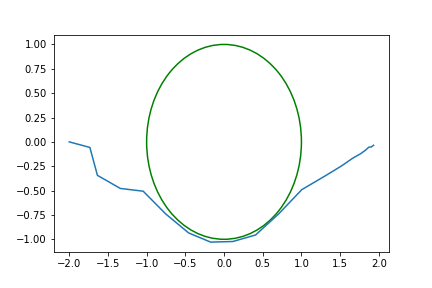

In [21]:
import ipympl
import matplotlib.pyplot as plt
plt.clf()
plt.close('all')
fig, ax = plt.subplots()
plt.plot(*np.array(infer_traj).T)
c = plt.Circle((0, 0), 1, edgecolor='g', facecolor='white', clip_on=False, linewidth=1.5)
ax.add_patch(c)
plt.show()
plt.savefig('a.png')

In [139]:
with open('1model_PointEnv.txt') as f:
    lines = f.readlines()

In [142]:
s = []
for line in lines:
    s.lines[0].split()[13]

'1.000000'

### visualization on CBF

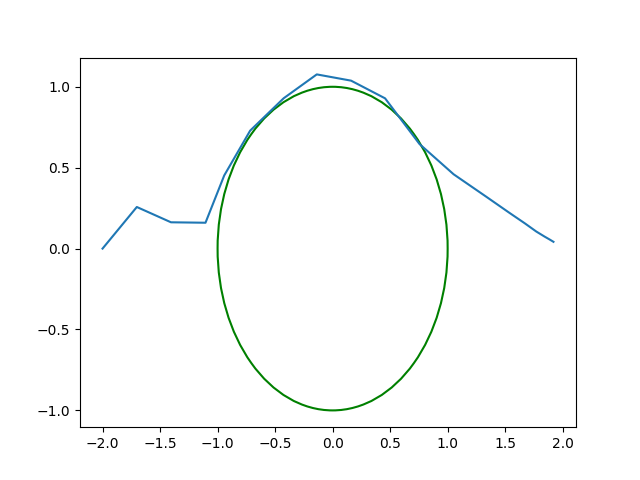

In [70]:
%matplotlib widget
import ipympl
import matplotlib.pyplot as plt
plt.clf()
plt.close('all')
fig, ax = plt.subplots()
plt.plot(*np.array(trajs[217]).T)
c = plt.Circle((0, 0), 1, edgecolor='g', facecolor='white', clip_on=False, linewidth=1.5)
ax.add_patch(c)
plt.show()

In [59]:
bnn(x=torch.FloatTensor(np.array(trajs[99])[:-1]).to(device), action=torch.FloatTensor(np.array(trajs[99])[1:,]-np.array(trajs[99])[:-1]).to(device)/0.3).data.cpu().numpy()

array([ 0.00615322,  0.0168369 ,  0.02461939,  0.03725697, -0.04950445,
        0.04675311, -0.01833821,  0.03422268,  0.08368017,  0.09180238,
        0.20361288,  0.3725643 ,  0.5286677 ,  0.6686999 ,  0.7717982 ,
        0.8585829 ,  0.907426  ,  0.94885206,  0.979881  ], dtype=float32)

In [42]:
trajs[59][1]

array([-1.73082578, -0.24192397])

In [133]:
bnn(x=torch.FloatTensor([-1.1, 0]).to(device), action=torch.FloatTensor([0.4, 0]).to(device))

tensor(0.0157, device='cuda:0', grad_fn=<SqueezeBackward1>)

### G

In [37]:
n_collide = 0
n_reach = 0
threshold = 1000
N_TEST = 1000
env.reset()
#     env.world.agents = env.world.sample_agents(env.num_agents, prob=0.0)
total_trans=0; n_danger=0; threshold=1e-2

while True:
    o = env._get_obs()
    a_best = nominal_control(o)
    a_other = np.random.uniform(-1., 1., size=(n_candidates-1, env.action_dim))
    a_all = np.zeros((n_candidates, env.action_dim))
    a_all[0, :] = a_best
    a_all[1:, :] = a_other

    o = {'x': torch.FloatTensor(o), 'goal': torch.FloatTensor(env.goal)}
    a_refine, bvalue = iter_action(bnn, o, a_other, max_iter=0, threshold=threshold)

    a, a_value = choose_action(a_refine, bvalue, threshold=threshold, explore_eps=0., nominal_eps=0.)

    next_o, rw, done, info = env.step(a_best)
    # if info['next_danger']:
    print(o['x'], a_value)
    n_collide += info['next_danger']

    threshold = 1e-2
    total_trans += 1
    n_danger += np.array(next_danger).sum()

    if done or (total_trans >= max_episode_length):
        n_reach += info['next_goal']
        break

tensor([-2.,  0.]) -0.13107894
tensor([-1.7000,  0.0000]) -0.122936025
tensor([-1.4000,  0.0000]) -0.11164804
tensor([-1.1000,  0.0000]) -0.10055794
tensor([-0.8000,  0.0000]) -0.09046771
tensor([-0.5000,  0.0000]) -0.082239956
tensor([-0.2000,  0.0000]) -0.0731955
tensor([0.1000, 0.0000]) -0.06821193
tensor([0.4000, 0.0000]) -0.07327388
tensor([0.7000, 0.0000]) -0.06384854
tensor([1., 0.]) -0.07175657
tensor([1.3000, 0.0000]) -0.08446115
tensor([1.5100, 0.0000]) -0.08590387
tensor([1.6570, 0.0000]) -0.079477355
tensor([1.7599, 0.0000]) -0.095163316
tensor([1.8319, 0.0000]) -0.08545959
tensor([1.8824, 0.0000]) -0.08211541


# benchmark

In [117]:
n_collide = 0
n_reach = 0
threshold = 1000
N_TEST = 100

for _ in tqdm(range(N_TEST)):
    
    infer_traj = [env.reset()]
    total_trans=0; n_danger=0; threshold=1e-2; collided=False
    env.state = env.state + np.random.uniform(-5e-2, 5e-2, size=(2,))

    while True:
        o = env._get_obs()
        a_all = np.hstack([i.reshape(-1, 1) for i in np.meshgrid(*([np.linspace(-1, 1, 20)]*2))])  #np.random.uniform(-1, 1, size=(n_candidates, env.action_dim))

        o = {'x': torch.FloatTensor(o), 'goal': torch.FloatTensor(env.goal)}
        a_refine, bvalue = iter_action(bnn, o, a_all, max_iter=0, threshold=threshold)

        dists = []
        for a in a_refine:
            next_state = a + env.state
            dists.append(np.linalg.norm(next_state-np.array([2, 0])))
        if np.any(bvalue>threshold):
            for a_idx in np.argsort(dists):
                if bvalue[a_idx] > threshold:
                    a = a_refine[a_idx]
                    break
        else:
            a = a_refine[np.argmax(bvalue)]

        next_o, rw, done, info = env.step(a)
        infer_traj.append(env.state.copy())
        # if info['next_danger']:
        # print(bvalue[0], bvalue.min(), bvalue.max(), threshold, a_value, 'TRUE' if info['next_danger'] else '')
        if info['next_danger']:
            collided = True
        
        total_trans += 1
        n_danger += np.array(next_danger).sum()

        if done or (total_trans >= max_episode_length):
            n_collide += collided
            n_reach += info['next_goal']
            break

100%|██████████| 100/100 [00:04<00:00, 22.23it/s]


In [118]:
n_collide

0

In [119]:
n_reach

100